In [41]:
import glob
import re
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

def read_file(filePath):
    transfers = []
    start = False
    with open(filePath,'r') as f:
        for line in f:
            if 'all' in line:
                start = True
                continue
            if start:
                if '--' in line:
                    return transfers
                tr = line.strip().split()
                tr[2] = int(tr[2])
                transfers.append(tr)
    return transfers

def make_unordered(transfers):
    newTrans = {}
    for (n0, n1, v) in transfers:
        if n0 < n1:
            k = (n0, n1)
        else:
            k = (n1, n0)
        s = newTrans.setdefault(k, 0)
        newTrans[k] = s + v
    return [(k,v) for k,v in newTrans.items()]

def get_transfers(gene_fam):
    gene_fam_path = f"../6_parse_reconciliation/parsed_test_{gene_fam}_agg_regB.out"
    trans_unordered = make_unordered(read_file(gene_fam_path))
    trans_sorted = sorted(trans_unordered,key=lambda x: x[1],reverse=True)
    res = []
    for tr in trans_sorted:
        res.append([tr[0][0], tr[0][1], tr[1], gene_fam])
    return res

In [42]:
gene_family_files

['../6_parse_reconciliation/parsed_test_ORF1ab_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF3a_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_S_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF6_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_E_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF7b_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF10_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_N_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF8_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_ORF7a_agg_regB.out',
 '../6_parse_reconciliation/parsed_test_M_agg_regB.out']

In [43]:
gene_family_files = glob.glob('../6_parse_reconciliation/parsed_test_*')
gene_families = [re.search('parsed_test_(.*)_agg_regB.out',f).group(1) for f in gene_family_files]
gene_fam_transfers = {gf: get_transfers(gf) for gf in gene_families}

In [44]:
gene_families

['ORF1ab',
 'ORF3a',
 'S',
 'ORF6',
 'E',
 'ORF7b',
 'ORF10',
 'N',
 'ORF8',
 'ORF7a',
 'M']

In [45]:
import pandas as pd
from functools import reduce

def create_df(df,df2):
    dfl = [df, df2]
    return pd.concat(dfl)

def check_family(fam,greater_than=0):
    fam_series = pd.DataFrame(all_pivot[[fam]].dropna().sort_values(by=[fam],ascending=False))
    return fam_series[fam_series.iloc[:,0] >= greater_than]

all_transfers = reduce(create_df, [pd.DataFrame(gene_fam_transfers[k]) for k in gene_families]).reset_index().drop(['index'],axis=1)
all_transfers.index = all_transfers[0]+'_'+all_transfers[1]

In [46]:
all_transfers

,0,1,2,3
n2_n35,n2,n35,1000,ORF1ab
KY4171461_n21,KY4171461,n21,1000,ORF1ab
KJ4738121_KY7708601,KJ4738121,KY7708601,1000,ORF1ab
KT4445821_KY4171431,KT4445821,KY4171431,1000,ORF1ab
DQ4120431_KJ4738141,DQ4120431,KJ4738141,1000,ORF1ab
...,...,...,...,...
AY5720381_n14,AY5720381,n14,4,M
n2_n33,n2,n33,4,M
NC0047183_n33,NC0047183,n33,4,M
AY5720341_n2,AY5720341,n2,4,M


In [47]:
def get_transfers_ordered(gene_fam):
    gene_fam_path = f"../6_parse_reconciliation/parsed_test_{gene_fam}_agg_regB.out"
    trans_ordered = read_file(gene_fam_path)
    trans_sorted = sorted(trans_ordered,key=lambda x: x[1],reverse=True)
    res = []
    for tr in trans_sorted:
        res.append([tr[0], tr[1], tr[2], gene_fam])
    return res

In [48]:
transfers_ordered = {gf: pd.DataFrame(get_transfers_ordered(gf)) for gf in gene_families}
all_transfers[4] = all_transfers[5] = 0

for i, row in enumerate(all_transfers.iterrows()):
    forward = transfers_ordered[row[1][3]][(transfers_ordered[row[1][3]][1] == row[1][1]) & (transfers_ordered[row[1][3]][0] == row[1][0])][2]
    if len(forward):
        forward = forward.item()
    else:
        forward = 0
    all_transfers.iloc[i,4] = forward
    backward = transfers_ordered[row[1][3]][(transfers_ordered[row[1][3]][1] == row[1][0]) & (transfers_ordered[row[1][3]][0] == row[1][1])][2]
    if len(backward):
        backward = backward.item()
    else:
        backward = 0
    all_transfers.iloc[i,5] = backward

In [49]:
all_transfers

,0,1,2,3,4,5
n2_n35,n2,n35,1000,ORF1ab,537,463
KY4171461_n21,KY4171461,n21,1000,ORF1ab,417,583
KJ4738121_KY7708601,KJ4738121,KY7708601,1000,ORF1ab,467,533
KT4445821_KY4171431,KT4445821,KY4171431,1000,ORF1ab,0,1000
DQ4120431_KJ4738141,DQ4120431,KJ4738141,1000,ORF1ab,520,480
...,...,...,...,...,...,...
AY5720381_n14,AY5720381,n14,4,M,4,0
n2_n33,n2,n33,4,M,0,4
NC0047183_n33,NC0047183,n33,4,M,0,4
AY5720341_n2,AY5720341,n2,4,M,4,0


In [50]:
pctl90 = np.quantile(all_transfers[2],0.90)
pctl95 = np.quantile(all_transfers[2],0.95)
pctl99 = np.quantile(all_transfers[2],0.99)
pctl995 = np.quantile(all_transfers[2],0.99)
print('90:',pctl90)
print('95:',pctl95)
print('99:',pctl99)
print('995:',pctl995)

90: 408.00000000000136
95: 700.0
99: 1000.0
995: 1000.0


In [51]:
all_transfers[7] = (all_transfers[4] / (all_transfers[4] + all_transfers[5]))

In [52]:
all_bidirectional = all_transfers[(all_transfers[4] >= 100) & (all_transfers[5] >= 100) & (0.4 <= all_transfers[7]) & (all_transfers[7] <= 0.6)].sort_values(by=2,ascending=False)

In [53]:
all_bidirectional.iloc[:,2:].to_csv('bidirectional_transfer_list.csv',header=None,index=True)

In [54]:
48 * 2

96

In [55]:
print(all_bidirectional.shape)
all_bidirectional.head(10)

(48, 7)


,0,1,2,3,4,5,7
n2_n35,n2,n35,1000,ORF1ab,537,463,0.537000
KY4171431_MK2113781,KY4171431,MK2113781,1000,S,511,489,0.511000
KJ4738121_KY7708601,KJ4738121,KY7708601,1000,ORF1ab,467,533,0.467000
DQ4120431_KJ4738141,DQ4120431,KJ4738141,1000,ORF1ab,520,480,0.520000
DQ0716151_JX9939871,DQ0716151,JX9939871,1000,M,533,467,0.533000
KY4171461_n21,KY4171461,n21,1000,ORF1ab,417,583,0.417000
KJ4738161_KY7708581,KJ4738161,KY7708581,1000,S,497,503,0.497000
KJ4738121_KY7708601,KJ4738121,KY7708601,1000,S,465,535,0.465000
KJ4738151_KU9736921,KJ4738151,KU9736921,928,E,491,437,0.529095
KP8868081_n40,KP8868081,n40,900,S,462,438,0.513333


In [56]:
all_ordered_transfers = reduce(create_df, transfers_ordered.values()).sort_values(2,ascending=False)

In [57]:
clean_transfer_table = all_ordered_transfers[[0,1,3,2]].sort_values(by=[2,3],ascending=False)
clean_transfer_table.columns = ['Donor','Recipient','Gene Family','Support']
aa = bb = cc = 0
for gf in gene_families:
    print(gf)
    a = len(clean_transfer_table[(clean_transfer_table['Support'] >= 100) & (clean_transfer_table['Gene Family'] == gf)])
    b = len(clean_transfer_table[(clean_transfer_table['Support'] >= 500) & (clean_transfer_table['Gene Family'] == gf)])
    c = len(clean_transfer_table[(clean_transfer_table['Support'] >= 808) & (clean_transfer_table['Gene Family'] == gf)])
    print(a,b,c)
    aa += a
    bb += b
    cc += c
    print('-----')
print(aa,bb,cc)

ORF1ab
42 11 3
-----
ORF3a
47 10 6
-----
S
54 13 4
-----
ORF6
50 6 2
-----
E
51 0 0
-----
ORF7b
48 0 0
-----
ORF10
26 2 0
-----
N
74 9 2
-----
ORF8
68 4 1
-----
ORF7a
65 12 4
-----
M
63 11 3
-----
588 78 25


In [58]:
all_ordered_transfers

,0,1,2,3
87,DQ0716151,DQ4120431,1000,S
46,n15,MK2113751,1000,S
20,DQ0716151,n36,1000,ORF3a
46,KY4171431,KT4445821,1000,ORF1ab
14,KJ4738151,n44,1000,S
...,...,...,...,...
103,n25,n20,1,E
80,n9,MK2113751,1,ORF7b
56,n28,n34,1,E
60,n6,n2,1,ORF7b


In [59]:
clean_transfer_table = all_ordered_transfers[[0,1,3,2]].sort_values(by=[2,3],ascending=False)
clean_transfer_table.columns = ['Donor','Recipient','Gene Family','Support']
#clean_transfer_table = clean_transfer_table[(clean_transfer_table['Support'] >= 100)]
print(len(clean_transfer_table))
clean_transfer_table.head(10)
#clean_transfer_table.to_csv('TransferTableClean.tsv',index=None,sep='\t')
#clean_transfer_table

1530


,Donor,Recipient,Gene Family,Support
87,DQ0716151,DQ4120431,S,1000
46,n15,MK2113751,S,1000
14,KJ4738151,n44,S,1000
103,GQ1535421,KJ4738151,ORF7a,1000
109,KF5699961,JX9939881,ORF7a,1000
20,DQ0716151,n36,ORF3a,1000
46,KY4171431,KT4445821,ORF1ab,1000
18,KY9385581,n43,M,1000
115,n44,JX9939871,ORF6,980
189,KY4171421,KJ4738161,M,972


In [60]:
leaf_donor = clean_transfer_table[~clean_transfer_table['Donor'].str.startswith('n')]
leaf_to_leaf = leaf_donor[~leaf_donor['Recipient'].str.startswith('n')]
leaf_to_leaf = leaf_to_leaf[leaf_to_leaf['Support'] >= 100]

In [61]:
leaf_to_leaf[leaf_to_leaf['Support'] >= 500]

,Donor,Recipient,Gene Family,Support
87,DQ0716151,DQ4120431,S,1000
103,GQ1535421,KJ4738151,ORF7a,1000
109,KF5699961,JX9939881,ORF7a,1000
46,KY4171431,KT4445821,ORF1ab,1000
189,KY4171421,KJ4738161,M,972
157,KY4171461,KY4171471,M,969
101,KY4171431,KY4171421,ORF7a,951
105,MK2113771,KY4171511,ORF8,903
90,JX9939871,DQ0716151,ORF3a,900
83,GQ1535421,KJ4738151,ORF3a,900


In [62]:
clean_transfer_table

,Donor,Recipient,Gene Family,Support
87,DQ0716151,DQ4120431,S,1000
46,n15,MK2113751,S,1000
14,KJ4738151,n44,S,1000
103,GQ1535421,KJ4738151,ORF7a,1000
109,KF5699961,JX9939881,ORF7a,1000
...,...,...,...,...
64,KJ4738151,n15,ORF7b,1
87,KY4171471,n25,E,1
207,n46,KJ4738151,E,1
103,n25,n20,E,1


In [63]:
sarsSpeciesList = ['n2','n3','n46','n47','n48','n49','n50','n51','n52','n53','Wuhan-Hu-1','RaTG13','P4L','P2V','P5E','P1E','P5L','CoVZXC21','CoVZC45']

In [64]:
transfersSarsSpecies = clean_transfer_table[clean_transfer_table['Donor'].isin(sarsSpeciesList) | clean_transfer_table['Recipient'].isin(sarsSpeciesList)]
pivotSarsSpecies = transfersSarsSpecies.pivot_table(index=['Donor','Recipient'],columns='Gene Family',values='Support').fillna(0)
pivotSarsSpecies

Gene Family             E     M      N  ORF10  ORF1ab  ORF3a  ORF6  ORF7a  \
Donor     Recipient                                                         
AY5720341 n2          0.0   4.0    0.0    0.0     0.0    0.0   0.0    0.0   
AY5720381 n2          0.0  17.0    0.0    0.0     0.0    0.0   0.0    0.0   
AY6868641 n2          0.0  11.0    0.0    0.0     0.0    0.0   0.0    0.0   
DQ0716151 n2         25.0   0.0    0.0   43.0     0.0    0.0   0.0    0.0   
DQ4120431 n2          0.0   0.0  107.0    0.0     0.0    0.0   0.0    0.0   
...                   ...   ...    ...    ...     ...    ...   ...    ...   
n6        n2          0.0   0.0    0.0    0.0     0.0    0.0   0.0    0.0   
          n47         0.0   0.0    0.0    0.0     0.0    0.0   0.0    0.0   
n8        n46         0.0   0.0    0.0    0.0     0.0    0.0   0.0    0.0   
n9        n2          0.0   0.0    0.0   57.0     0.0    0.0   0.0    0.0   
          n46         0.0  28.0    0.0    0.0     0.0    0.0   0.0    0.0   

Gene Family          ORF7b   ORF8     S  
Donor     Recipient                      
AY5720341 n2           0.0    0.0   0.0  
AY5720381 n2           0.0    0.0   0.0  
AY6868641 n2           0.0    0.0   0.0  
DQ0716151 n2           0.0    0.0   0.0  
DQ4120431 n2           0.0    0.0   0.0  
...                    ...    ...   ...  
n6        n2           1.0    0.0   0.0  
          n47          0.0    0.0  27.0  
n8        n46          0.0  100.0   0.0  
n9        n2           0.0    0.0   0.0  
          n46          0.0   31.0   0.0  

[185 rows x 11 columns]

In [65]:
transfersSarsSpecies.head(10)

,Donor,Recipient,Gene Family,Support
4,n49,n50,N,813
9,n40,n47,N,715
5,n51,n47,ORF1ab,700
6,n49,n50,S,640
48,n50,n2,ORF7a,600
28,NC0144701,n46,ORF10,539
8,n2,n35,ORF1ab,537
18,n48,n2,ORF1ab,537
12,n47,n4,N,500
7,n48,n35,ORF1ab,463


In [67]:
all_transfers[6] = list(zip(all_transfers[4],all_transfers[5]))
all_transfers[7] = (all_transfers[4]/(all_transfers[4] + all_transfers[5]))

In [75]:
all_transfers

,0,1,2,3,4,5,7,6
n2_n35,n2,n35,1000,ORF1ab,537,463,0.537,"(537, 463)"
KY4171461_n21,KY4171461,n21,1000,ORF1ab,417,583,0.417,"(417, 583)"
KJ4738121_KY7708601,KJ4738121,KY7708601,1000,ORF1ab,467,533,0.467,"(467, 533)"
KT4445821_KY4171431,KT4445821,KY4171431,1000,ORF1ab,0,1000,0.000,"(0, 1000)"
DQ4120431_KJ4738141,DQ4120431,KJ4738141,1000,ORF1ab,520,480,0.520,"(520, 480)"
...,...,...,...,...,...,...,...,...
AY5720381_n14,AY5720381,n14,4,M,4,0,1.000,"(4, 0)"
n2_n33,n2,n33,4,M,0,4,0.000,"(0, 4)"
NC0047183_n33,NC0047183,n33,4,M,0,4,0.000,"(0, 4)"
AY5720341_n2,AY5720341,n2,4,M,4,0,1.000,"(4, 0)"


In [68]:
all_pivot_directional = all_transfers.pivot(None,3,7)#.fillna(-1)
all_pivot_ratio = all_transfers.pivot(None,3,6)
all_pivot = all_transfers.pivot(None,3,2).fillna(0)
all_pivot_ratio['Total'] = all_pivot_directional['Total'] = all_pivot['Total'] = all_pivot.sum(axis=1)
all_pivot = all_pivot.sort_values(['Total'],ascending=False)[['ORF1ab','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10','Total']]
all_pivot_directional = all_pivot_directional.sort_values(['Total'],ascending=False)[['ORF1ab','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10','Total']]
all_pivot_ratio = all_pivot_ratio.sort_values(['Total'],ascending=False)[['ORF1ab','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10','Total']]

In [74]:
all_pivot

3,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF10,Total
JX9939881_KF5699961,0.0,0.0,0.0,60.0,123.0,1000.0,1000.0,200.0,863.0,0.0,0.0,3246.0
JX9939871_n44,0.0,0.0,900.0,100.0,0.0,1000.0,0.0,800.0,15.0,0.0,0.0,2815.0
KJ4738121_KY7708601,1000.0,1000.0,0.0,0.0,0.0,0.0,151.0,0.0,46.0,500.0,65.0,2762.0
DQ0716151_JX9939871,0.0,0.0,1000.0,0.0,1000.0,20.0,0.0,0.0,481.0,0.0,0.0,2501.0
KP8868081_n40,0.0,900.0,900.0,0.0,672.0,0.0,0.0,0.0,0.0,0.0,0.0,2472.0
...,...,...,...,...,...,...,...,...,...,...,...,...
NC0144701_n26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
MK2113751_n37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
KY4171471_n25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
n2_n6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [70]:
all_ancestral = all_pivot[all_pivot.index.str.startswith('n')]
all_ancestral_directional = all_pivot_directional[all_pivot.index.str.startswith('n')]
all_ancestral_ratio = all_pivot_ratio[all_pivot.index.str.startswith('n')]

In [71]:
# all_pivot_directional.to_csv('all_pivot_directional.csv')
# all_ancestral_directional.to_csv('ancestral_only_directional.csv')

---

In [72]:
all_ancestral

3,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF10,Total
n49_n50,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,0.0,1900.0
n2_n46,0.0,28.0,100.0,400.0,200.0,0.0,300.0,400.0,0.0,0.0,0.0,1428.0
n2_n35,1000.0,0.0,0.0,64.0,85.0,0.0,0.0,18.0,0.0,0.0,0.0,1167.0
n35_n5,0.0,0.0,0.0,0.0,549.0,300.0,0.0,0.0,0.0,0.0,0.0,849.0
n38_n6,0.0,794.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,794.0
...,...,...,...,...,...,...,...,...,...,...,...,...
n20_n40,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
n18_n24,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
n2_n33,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
n15_n36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0


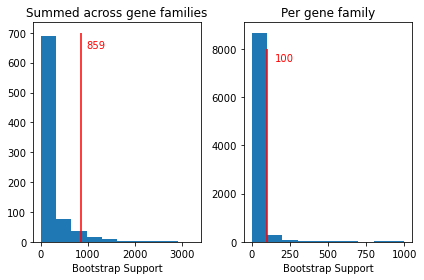

Top 5% of Transfers: >=100.0


In [73]:
all_without_total = all_pivot.iloc[:,:-1]
import matplotlib.pyplot as plt
import numpy as np
across_fams = all_without_total.values.sum(axis=1)
per_fam = all_without_total.values.ravel()
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(across_fams)
ax1.set_xlabel("Bootstrap Support")
ax1.set_title('Summed across gene families')
ax1.vlines(np.quantile(across_fams,0.95),0,700,'r')
ax1.text(np.quantile(across_fams,0.95) + 100,650,int(np.quantile(across_fams,0.95)), {'color':'r'})
ax2.hist(per_fam)
ax2.set_xlabel("Bootstrap Support")
ax2.set_title('Per gene family')
ax2.vlines(np.quantile(per_fam,0.95),0,8000,'r')
ax2.text(np.quantile(per_fam,0.95) + 50,7500,int(np.quantile(per_fam,0.95)), {'color':'r'})
fig.tight_layout()
plt.savefig("transfer_bootstrap_support.svg")
plt.savefig("transfer_bootstrap_support.eps")
plt.show()

print(f'Top 5% of Transfers: >={np.quantile(all_without_total.values.ravel(),0.95)}')

In [114]:
np.quantile(per_fam,0.995)

808.6000000000058

In [116]:
def permute_rows(A):
    return np.random.permutation(A)

def permute_cols(A):
    return np.random.permutation(A.T).T

def check_has_window(R,n,k,t):
    cols = len(R)
    c = 0
    while c+n <= cols:
        if np.sum(R[c:c+n] >= t) >= k:
            return True
        c += 1
    return False

def find_grouped_transfers(A,n,k,t,print_rows=False):
    """
    A: (r x c) matrix
    Find the number of rows with at least one window of width n<=c with at least k transfers with at least 2 bootstrap support
    """
    found_indices = []
    
    rows, cols = A.shape
    num_rows_found = 0
    for r in range(rows):
        if check_has_window(A[r,:],n,k,t):
            if print_rows: print(r, A[r,:])
            found_indices.append(r)
    return found_indices

In [117]:
n = 2
k = 2
t = 100
#A = all_ancestral.iloc[:,:-1].values
DF = all_pivot
A = DF.iloc[:,:-1].values
NUM_BOOTS = 500000
preshuffle_rows = False

vals = []
found_random = 0
checked_random = 0
for _ in tqdm(range(NUM_BOOTS)):
    if preshuffle_rows:
        permuted = np.random.permutation(A.ravel()).reshape(A.shape)
    else:
        permuted = permute_cols(A)
    rand_row = permuted[np.random.choice(permuted.shape[0]),:]
    if np.sum(rand_row >= t) >= k:
        checked_random += 1
#     if (rand_row >= t).any():
#         checked_random += 1
#     if True:
#         checked_random += 1
    
    #nw, tw = find_grouped_transfers(permuted,n,k,t)
    if check_has_window(rand_row,n,k,t):
        found_random += 1
    #vals.append(nw)

print(f"Out of {checked_random} randomly generated rows with {k} significant transfers, {found_random} had at least one window \nof size {n} with {k} transfers with greater than {t} support (p={found_random / checked_random})\n")

found_indices = find_grouped_transfers(A,n,k,t,print_rows=False)
print(f"There are {len(found_indices)} such rows (out of {((A >= t).sum(axis=1) >= k).sum()} with at least {k} significant transfers):")

from scipy.stats import binom_test
print(f"Binomial Test: {binom_test(len(found_indices), ((A >= t).sum(axis=1) >= k).sum() ,(found_random / checked_random),'greater')}")

for r in found_indices:
    print(DF.iloc[r,:])

  0%|          | 0/500000 [00:00<?, ?it/s]

Out of 50590 randomly generated rows with 2 significant transfers, 14743 had at least one window 
of size 2 with 2 transfers with greater than 100 support (p=0.29142122949199445)

There are 39 such rows (out of 85 with at least 2 significant transfers):
Binomial Test: 0.0007917228626897698
3
ORF1ab       0.0
S            0.0
ORF3a        0.0
E           60.0
M          123.0
ORF6      1000.0
ORF7a     1000.0
ORF7b      200.0
ORF8       863.0
N            0.0
ORF10        0.0
Total     3246.0
Name: JX9939881_KF5699961, dtype: float64
3
ORF1ab       0.0
S            0.0
ORF3a      900.0
E          100.0
M            0.0
ORF6      1000.0
ORF7a        0.0
ORF7b      800.0
ORF8        15.0
N            0.0
ORF10        0.0
Total     2815.0
Name: JX9939871_n44, dtype: float64
3
ORF1ab    1000.0
S         1000.0
ORF3a        0.0
E            0.0
M            0.0
ORF6         0.0
ORF7a      151.0
ORF7b        0.0
ORF8        46.0
N          500.0
ORF10       65.0
Total     2762.0
Name: KJ47381

---

In [29]:
leaf_names = set(all_transfers[0]).union(set(all_transfers[1]))
leaf_names = set([i for i in leaf_names if not re.match('n.+',i)])

In [33]:
nameMap = pd.read_csv('/afs/csail/u/s/samsl/Work/Covid_Phylogenetics/data_raw/speciesNameMapFinal.csv',sep=',',header=None)
nameMap[0] = nameMap[0].apply(lambda x: ''.join(x.strip('_').split('_')))
nameMap = nameMap.set_index(0)

In [40]:
namesPlus = [f"{i}1" for i in nameMap.index]
namesPlus.sort()
namesPlus[5] = 'DQ0223052'
namesPlus[-3] = 'NC0047183'

In [42]:
renamed_table = clean_transfer_table.replace(namesPlus, nameMap[3].sort_index().values)
renamed_table.to_csv('OptRoot_Transfers_All.csv',index=False)

In [43]:
leaf_donor = renamed_table[~renamed_table['Donor'].str.startswith('n')]
leaf_to_leaf = leaf_donor[~leaf_donor['Recipient'].str.startswith('n')]
leaf_to_leaf = leaf_to_leaf[leaf_to_leaf['Support'] >= 100]

In [45]:
anc_donor = renamed_table[renamed_table['Donor'].str.startswith('n')]
anc_to_anc = anc_donor[anc_donor['Recipient'].str.startswith('n')]
anc_to_anc = anc_to_anc[anc_to_anc['Support'] >= 100]

In [49]:
anc_to_anc[anc_to_anc['Support'] >= 500]

,Donor,Recipient,Gene Family,Support
4,n49,n50,N,813
9,n40,n47,N,715
5,n51,n47,ORF1ab,700
6,n49,n50,S,640
48,n50,n2,ORF7a,600
6,n35,n5,M,549
8,n2,n35,ORF1ab,537
18,n48,n2,ORF1ab,537
21,n6,n38,S,502
2,n38,n5,ORF3a,500


In [44]:
leaf_to_leaf[leaf_to_leaf['Support'] >= 500]

,Donor,Recipient,Gene Family,Support
87,Rp3,Rm1,S,1000
103,HKU3_7,GX2013,ORF7a,1000
109,LYRa11,CpY11,ORF7a,1000
46,Rs4081,WIV16,ORF1ab,1000
189,As6526,YN2013,M,972
157,Rs4231,Rs4247_147,M,969
101,Rs4081,As6526,ORF7a,951
105,YN2018C,Rs7327,ORF8,903
90,RpS11,Rp3,ORF3a,900
83,HKU3_7,GX2013,ORF3a,900


In [122]:
import numpy as np
def make_circos_table(transfer_list, gene_family, name_map=None, threshold=100):
    fam_list = transfer_list[transfer_list[3] == gene_family]
    fam_leaf_names = [i for i in set(fam_list[0]).union(set(fam_list[1])) if not re.match('n.+',i)]
    print(len(fam_leaf_names))
    if name_map is not None:
        fam_leaf_names = [nameMap.loc[n[:-1],3] for n in fam_leaf_names]
    pairwise = pd.DataFrame(np.zeros((len(fam_leaf_names),len(fam_leaf_names))),index=fam_leaf_names,columns=fam_leaf_names)
    for (i,j,k) in zip(fam_list[0],fam_list[1],fam_list[2]):
        if not (re.match('n.+',i) or re.match('n.+',j)):
            if name_map is not None:
                i = nameMap.loc[i[:-1],3]
                j = nameMap.loc[j[:-1],3]
            if k >= threshold:
                pairwise.loc[i,j] = k
    return pairwise

In [123]:
greater500 = all_ordered_transfers[all_ordered_transfers[2] >= 500]
greater808 = all_ordered_transfers[all_ordered_transfers[2] >= 808]

In [124]:
#greater808[greater808[1].str.startswith('n')].to_csv('greater_808_timecheck.tsv',sep='\t',header=None,index=None)
#greater500[greater500[1].str.startswith('n')].to_csv('greater_500_timecheck.tsv',sep='\t',header=None,index=None)

In [125]:
len(greater500) - len(greater500[greater500[1].str.startswith('n')]) + 26

75

In [126]:
merged_all_ordered = pd.merge(all_ordered_transfers,mad_all_ordered,left_on=[0,1],right_on=[0,1])
merged_with_support = merged_all_ordered[merged_all_ordered['3_x'] == merged_all_ordered['3_y']]
merged_with_support['support'] = np.min([merged_with_support['2_y'].values,merged_with_support['2_x'].values],axis=0)
merged_with_support = merged_with_support[[0,1,'support','3_x']]
merged_with_support.columns = [0,1,2,3]

/data/cb/samsl/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
hicon = merged_with_support[merged_with_support[2] >= 100]
hicon

,0,1,2,3
0,n15,MK2113751,1000,S
4,KY4171431,KT4445821,1000,ORF1ab
5,KJ4738151,n44,1000,S
9,KJ4738151,n44,219,ORF7b
13,KJ4738151,n44,100,ORF3a
...,...,...,...,...
1034,KY4171421,n26,100,ORF6
1035,n26,KY4171421,100,ORF6
1036,n42,MK2113771,100,ORF7b
1037,n35,DQ0716151,100,ORF6


In [128]:
geneFamCounts = all_ordered_transfers[all_ordered_transfers[2] >= 100].groupby(3).count().loc[['ORF1ab','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10'],:].reset_index()

In [129]:
geneFamCounts

,3,0,1,2
0,ORF1ab,42,42,42
1,S,54,54,54
2,ORF3a,47,47,47
3,E,51,51,51
4,M,63,63,63
5,ORF6,50,50,50
6,ORF7a,65,65,65
7,ORF7b,48,48,48
8,ORF8,68,68,68
9,N,74,74,74


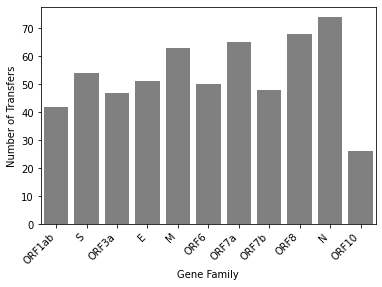

In [130]:
sns.barplot(data=geneFamCounts,x=3,y=0,color='gray')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Gene Family')
plt.ylabel('Number of Transfers')
plt.savefig('../fig/geneFamilyTransferBarplot.svg')

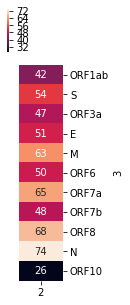

In [131]:
sns.clustermap(data=geneFamCounts.iloc[:,[3,0]].set_index(3),annot=True,row_cluster=False,col_cluster=False,figsize=(1,5))

ORF1ab
20


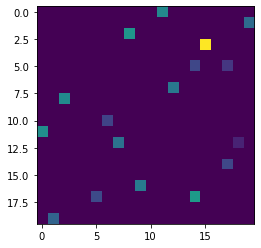

S
28


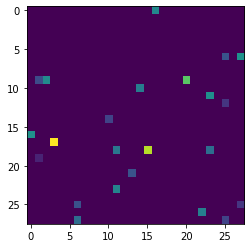

ORF3a
26


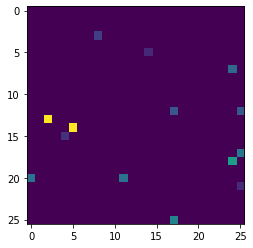

E
26


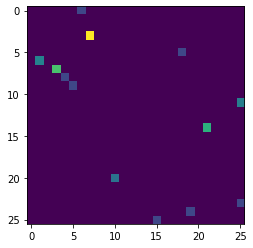

M
26


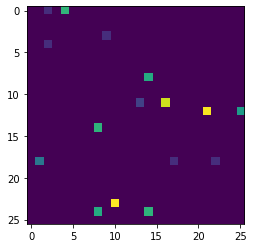

ORF6
25


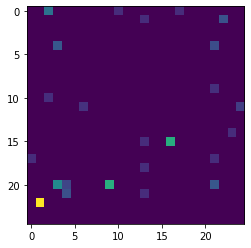

ORF7a
35


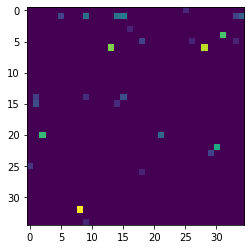

ORF7b
23


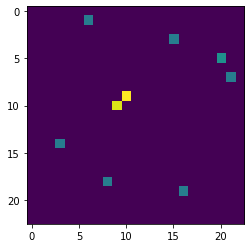

ORF8
29


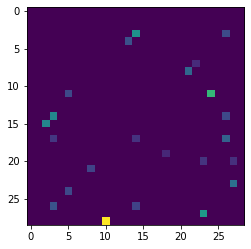

N
31


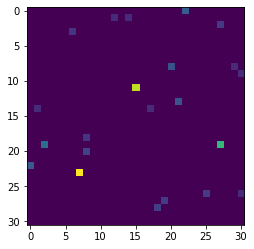

ORF10
25


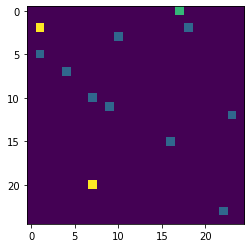

In [132]:
import matplotlib.pyplot as plt
import sys
circos_tables = {}
for gene_family in all_pivot.columns[:-1]:
    print(gene_family)
    circos_table = make_circos_table(merged_with_support,gene_family,name_map=nameMap)
    circos_table.columns.name = '-'
    plt.imshow(circos_table.values)
    plt.show()
    circos_tables[gene_family] = circos_table
    #circos_table.to_csv(f'../circos/circos_both_{gene_family}.tsv',sep='\t',index_label='-')

In [133]:
check_family('E',greater_than=300)

3,E
KJ4738151_KU9736921,928.0
DQ0716151_KF5699961,461.0
n2_n46,400.0
KY4171441_n19,400.0
MK2113751_n40,400.0
MK2113771_n30,400.0
KY4171481_MK2113741,300.0


In [134]:
test_table = all_pivot[~all_pivot.index.str.contains('n')]
test_table[test_table['Total'] >= 200].head(60)

3,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF10,Total
JX9939881_KF5699961,0.0,0.0,0.0,60.0,123.0,1000.0,1000.0,200.0,863.0,0.0,0.0,3246.0
KJ4738121_KY7708601,1000.0,1000.0,0.0,0.0,0.0,0.0,151.0,0.0,46.0,500.0,65.0,2762.0
DQ0716151_JX9939871,0.0,0.0,1000.0,0.0,1000.0,20.0,0.0,0.0,481.0,0.0,0.0,2501.0
GQ1535421_KJ4738151,0.0,0.0,900.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,1900.0
KY4171421_KY4171491,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,856.0,822.0,0.0,1878.0
KY4171511_KY4171521,240.0,777.0,388.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1505.0
KY4171461_KY4171471,417.0,0.0,0.0,0.0,992.0,0.0,0.0,0.0,0.0,0.0,0.0,1409.0
DQ4120431_KJ4738141,1000.0,0.0,0.0,0.0,0.0,20.0,100.0,0.0,51.0,132.0,44.0,1347.0
FJ5886861_MK2113751,0.0,0.0,0.0,0.0,0.0,187.0,0.0,100.0,882.0,0.0,0.0,1169.0
KY4171421_KY4171431,0.0,0.0,0.0,0.0,0.0,39.0,951.0,0.0,165.0,0.0,0.0,1155.0


In [135]:
all_nc = all_pivot[all_pivot.index.str.contains('AY')]
all_nc.head(50)

3,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF10,Total
AY5720381_DQ0716151,838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,838.0
AY5720351_NC0047183,0.0,0.0,0.0,0.0,0.0,100.0,600.0,0.0,0.0,0.0,100.0,800.0
AY5720351_AY5720381,0.0,0.0,500.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0
AY5720381_AY6868641,0.0,0.0,0.0,0.0,109.0,0.0,0.0,0.0,0.0,400.0,0.0,509.0
AY5720351_AY6868641,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,400.0
AY5720341_AY6868631,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,0.0,327.0
AY6868631_AY6868641,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,97.0,0.0,297.0
AY5720341_AY5720381,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0.0,0.0,175.0,0.0,243.0
AY5720341_AY6868641,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,225.0,0.0,237.0
AY5720341_KY4171451,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0


In [136]:
all_ancestral = all_pivot[all_pivot.index.str.startswith('n')]
all_ancestral.head(50)

3,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF10,Total
n49_n50,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,0.0,1900.0
n2_n46,0.0,28.0,100.0,400.0,200.0,0.0,300.0,400.0,0.0,0.0,0.0,1428.0
n2_n35,1000.0,0.0,0.0,64.0,85.0,0.0,0.0,18.0,0.0,0.0,0.0,1167.0
n35_n5,0.0,0.0,0.0,0.0,549.0,300.0,0.0,0.0,0.0,0.0,0.0,849.0
n38_n6,0.0,794.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,794.0
n35_n46,0.0,0.0,0.0,236.0,116.0,100.0,0.0,41.0,217.0,0.0,68.0,778.0
n40_n47,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,715.0,0.0,766.0
n47_n51,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,754.0
n46_n5,0.0,0.0,0.0,0.0,200.0,68.0,0.0,286.0,0.0,0.0,193.0,747.0
n2_n50,0.0,0.0,0.0,76.0,0.0,0.0,600.0,46.0,0.0,0.0,0.0,722.0


---

# Count Transfers per Gene Family

In [137]:
namesPlus = [f"{i}1" for i in nameMap.index]
namesPlus.sort()
namesPlus[5] = 'DQ0223052'

In [138]:
transfers_renamed = all_ordered_transfers.replace(namesPlus, nameMap[3].sort_index().values)

In [139]:
transfers_sig = transfers_renamed[transfers_renamed[2] >= 100]

In [140]:
print('hello world')

hello world


In [141]:
transfers_sig

,0,1,2,3
46,n15,YN2018A,1000,S
46,Rs4081,WIV16,1000,ORF1ab
14,GX2013,n44,1000,S
20,Rp3,n36,1000,ORF3a
87,Rp3,Rm1,1000,S
...,...,...,...,...
78,WIV1,YN2018B,100,ORF7b
33,YN2018A,n26,100,ORF6
114,Rs4084,SC2018,100,ORF10
117,n35,Rp3,100,ORF6


In [142]:
gene_fam_tab = transfers_sig.groupby(3).sum()

# Count Transfers Per Node

In [143]:
transfers_renamed

,0,1,2,3
46,n15,YN2018A,1000,S
46,Rs4081,WIV16,1000,ORF1ab
14,GX2013,n44,1000,S
20,Rp3,n36,1000,ORF3a
87,Rp3,Rm1,1000,S
...,...,...,...,...
207,n46,GX2013,1,E
103,n25,n20,1,E
56,n28,n34,1,E
87,Rs4247_147,n25,1,E


In [80]:
from ete3 import Tree

In [82]:
speciesTree = Tree("../supplements/FigS1_species_tree.newick",format=8)

In [83]:
namesPlus = [f"{i}1" for i in nameMap.index]
namesPlus.sort()
namesPlus[5] = 'DQ0223052'

In [84]:
#hicon_renamed = hicon.replace(namesPlus, nameMap[3].sort_index().values)
transfers_renamed = all_ordered_transfers.replace(namesPlus, nameMap[3].sort_index().values)

In [85]:
transfers_renamed

,0,1,2,3
87,Rp3,Rm1,1000,S
46,n15,YN2018A,1000,S
20,Rp3,n36,1000,ORF3a
46,Rs4081,WIV16,1000,ORF1ab
14,GX2013,n44,1000,S
...,...,...,...,...
103,n25,n20,1,E
80,n9,YN2018A,1,ORF7b
56,n28,n34,1,E
60,n6,n2,1,ORF7b


In [148]:
pairwiseDict = {}

def check_between(n1, n2, transfers_renamed):
    df = transfers_renamed[((transfers_renamed[0] == n1) & (transfers_renamed[1] == n2)) | ((transfers_renamed[0] == n2) & (transfers_renamed[1] == n1))]
    return (len(df))

for node1 in tqdm(speciesTree.traverse("postorder"),total=2*len(speciesTree)-1):
    for node2 in speciesTree.traverse("postorder"):
        n1 = node1.name
        n2 = node2.name
        if n1 > n2:
            continue
        s = 0
        for c1 in node1.traverse("postorder"):
            for c2 in node2.traverse("postorder"):
                if c1.name < c2.name:
                    continue
                s += check_between(c1.name, c2.name, transfers_renamed[transfers_renamed[2] >= 100])
        #df = transfers_renamed[((transfers_renamed[0] == n1) & (transfers_renamed[1] == n2)) | ((transfers_renamed[0] == n2) & (transfers_renamed[1] == n1))]
        pairwiseDict[(n1,n2)] = s

  0%|          | 0/107 [00:00<?, ?it/s]

In [149]:
pairwiseDict.keys()

dict_keys([('BtKY72', 'BtKY72'), ('BtKY72', 'n2'), ('BtKY72', 'CpY11'), ('BtKY72', 'Rp3'), ('BtKY72', 'GX2013'), ('BtKY72', 'n9'), ('BtKY72', 'YN2013'), ('BtKY72', 'Rs4084'), ('BtKY72', 'n11'), ('BtKY72', 'YN2018A'), ('BtKY72', 'n10'), ('BtKY72', 'n8'), ('BtKY72', 'Rf4092'), ('BtKY72', 'YN2018B'), ('BtKY72', 'YN2018C'), ('BtKY72', 'n17'), ('BtKY72', 'YN2018D'), ('BtKY72', 'n16'), ('BtKY72', 'Rs4231'), ('BtKY72', 'n18'), ('BtKY72', 'n15'), ('BtKY72', 'WIV16'), ('BtKY72', 'Rs4081'), ('BtKY72', 'Rs4247_148'), ('BtKY72', 'n21'), ('BtKY72', 'n20'), ('BtKY72', 'WIV1'), ('BtKY72', 'Rs4255'), ('BtKY72', 'Rs9401'), ('BtKY72', 'n24'), ('BtKY72', 'n23'), ('BtKY72', 'Rs4247_147'), ('BtKY72', 'n22'), ('BtKY72', 'n19'), ('BtKY72', 'n14'), ('BtKY72', 'n13'), ('BtKY72', 'Rs672'), ('BtKY72', 'Rs7327'), ('BtKY72', 'n27'), ('BtKY72', 'n26'), ('BtKY72', 'SARS-CoV'), ('BtKY72', 'C020'), ('BtKY72', 'C007'), ('BtKY72', 'C010'), ('BtKY72', 'n33'), ('BtKY72', 'n32'), ('BtKY72', 'n31'), ('BtKY72', 'n30'), ('BtK

In [150]:
vals = []
valDict = {}

for x, v in pairwiseDict.items():
    vals.append((x,pairwiseDict[x] / (len(speciesTree.search_nodes(name=x[0])[0]) + len(speciesTree.search_nodes(name=x[1])[0]))))
    valDict[x] = pairwiseDict[x] / (len(speciesTree.search_nodes(name=x[0])[0]) + len(speciesTree.search_nodes(name=x[1])[0]))

In [151]:
np.mean([x[1] for x in vals])

0.13507984401585207

(array([5.389e+03, 2.060e+02, 9.400e+01, 3.900e+01, 9.000e+00, 6.000e+00,
        1.000e+01, 5.000e+00, 1.300e+01, 7.000e+00]),
 array([0.        , 0.57674419, 1.15348837, 1.73023256, 2.30697674,
        2.88372093, 3.46046512, 4.0372093 , 4.61395349, 5.19069767,
        5.76744186]),
 <BarContainer object of 10 artists>)

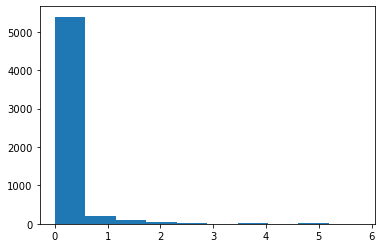

In [152]:
plt.hist([i[1] for i in vals])

In [156]:
x = ('n2', 'n46')
pairwiseDict[x] / (len(speciesTree.search_nodes(name=x[0])[0]) + len(speciesTree.search_nodes(name=x[1])[0]))

0.09090909090909091

In [157]:
len(speciesTree.search_nodes(name="")[0])

54

In [158]:
def get_transfers(tlist, node_name, in_or_out="in", thresh=0):
    if in_or_out == "in":
        in_or_out = 1
    elif in_or_out == "out":
        in_or_out = 0
    else:
        raise ValueError("in_or_out must be 'in' or 'out'")
    transfer_list = tlist[(tlist[in_or_out] == node_name) & (tlist[2] >= thresh)]
    return transfer_list

class NodeTransfers:
    def __init__(self,name):
        self.name = name
        self.selfIn = 0
        self.selfOut = 0
        self.treeIn = 0
        self.treeOut = 0
        self.len = 0
    
    def __repr__(self):
        return ' '.join(['{:.2f}'.format(i) for i in list(self.__dict__.values())[1:]])



In [159]:
transferDict = {}
threshold = 100

for node in speciesTree.traverse("postorder"):
    nt = NodeTransfers(node.name)
    nt.name = node.name
    nt.selfIn = len(get_transfers(transfers_renamed,node.name,'in',threshold))
    nt.selfOut = len(get_transfers(transfers_renamed,node.name,'out',threshold))
    nt.treeIn = nt.selfIn
    nt.treeOut = nt.selfOut
    nt.length = len(node)
    for c in node.children:
        nt.treeIn += transferDict[c.name].treeIn
        nt.treeOut += transferDict[c.name].treeOut
    node.nt = nt
    #print(node.name, nt)
    transferDict[node.name] = nt

In [160]:
transferDictNormalized = {}
for node in speciesTree.traverse():
    nt = transferDict[node.name]
    ntnorm = NodeTransfers(node.name)
    nt.name = node.name
    ntnorm.selfIn = nt.selfIn
    ntnorm.selfOut = nt.selfOut
    ntnorm.treeIn = nt.treeIn / len(node)
    ntnorm.treeOut = nt.treeOut / len(node)
    ntnorm.length = len(node)
    transferDictNormalized[node.name] = ntnorm
    node.ntnorm = ntnorm

In [161]:
names = []
lens = []
inList = []
outList = []
bothList = []
inTreeList = []
outTreeList = []
bothTreeList = []

for nt in transferDict.values():
    names.append(nt.name)
    lens.append(nt.length)
    inList.append(nt.selfIn)
    outList.append(nt.selfOut)
    bothList.append(nt.selfIn + nt.selfOut)
    inTreeList.append(nt.treeIn)
    outTreeList.append(nt.treeOut)
    bothTreeList.append(nt.treeIn + nt.treeOut)

In [162]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [163]:
print(pearsonr(lens,bothTreeList))
lr = LinearRegression()
lr.fit(np.array(lens).reshape(-1,1),bothTreeList)
print(lr.coef_, lr.intercept_)

(0.9869973440713569, 3.450873820301792e-85)
[23.4420866] -15.92829081092421


In [164]:
lensSARS, transSARS = [], []
for n, x, y in zip(names, lens, bothTreeList):
    if n in ['n46','n47','n48','n49','n50','n51','n52','n53','Wuhan-Hu-1','RaTG13','P4L','P2V','P5E','P1E','P5L','CoVZXC21','CoVZC45']:
        lensSARS.append(x)
        transSARS.append(y)
print(pearsonr(lensSARS, transSARS))
lr2 = LinearRegression()
lr2.fit(np.array(lensSARS).reshape(-1,1),transSARS)
print(lr2.coef_, lr2.intercept_)

(0.9500500073680709, 5.502426880507372e-09)
[7.7712] -7.710399999999993


In [165]:
lensWithout, transWithout = [], []
for n, x, y in zip(names, lens, bothTreeList):
    if not n in ['n46','n47','n48','n49','n50','n51','n52','n53','Wuhan-Hu-1','RaTG13','P4L','P2V','P5E','P1E','P5L','CoVZXC21','CoVZC45']:
        lensWithout.append(x)
        transWithout.append(y)
print(pearsonr(lensWithout, transWithout))
lr3 = LinearRegression()
lr3.fit(np.array(lensWithout).reshape(-1,1),transWithout)
print(lr3.coef_, lr3.intercept_)

(0.989926218068771, 1.6674865249826727e-76)
[23.41057337] -10.5210707136808


In [166]:
AllfitR, AllfitPval = pearsonr(lens,bothTreeList)
print(AllfitR, AllfitPval)
lr0 = LinearRegression()
lr0.fit(np.array(lens).reshape(-1,1),bothTreeList)
AllfitCoef, AllfitIntercept = lr0.coef_, lr0.intercept_
print(AllfitCoef, AllfitIntercept)

0.9869973440713569 3.450873820301792e-85
[23.4420866] -15.92829081092421


In [167]:
fitR, fitPval = pearsonr(lensWithout,transWithout)
print(fitR, fitPval)
lr = LinearRegression()
lr.fit(np.array(lensWithout).reshape(-1,1),transWithout)
fitCoef, fitIntercept = lr.coef_, lr.intercept_
print(fitCoef, fitIntercept)

0.989926218068771 1.6674865249826727e-76
[23.41057337] -10.5210707136808


In [168]:
HufitR, HufitPval = pearsonr(lensSARS,transSARS)
print(HufitR, HufitPval)
lr2 = LinearRegression()
lr2.fit(np.array(lensSARS).reshape(-1,1),transSARS)
HufitCoef, HufitIntercept = lr2.coef_, lr2.intercept_
print(HufitCoef, HufitIntercept)

0.9500500073680709 5.502426880507372e-09
[7.7712] -7.710399999999993


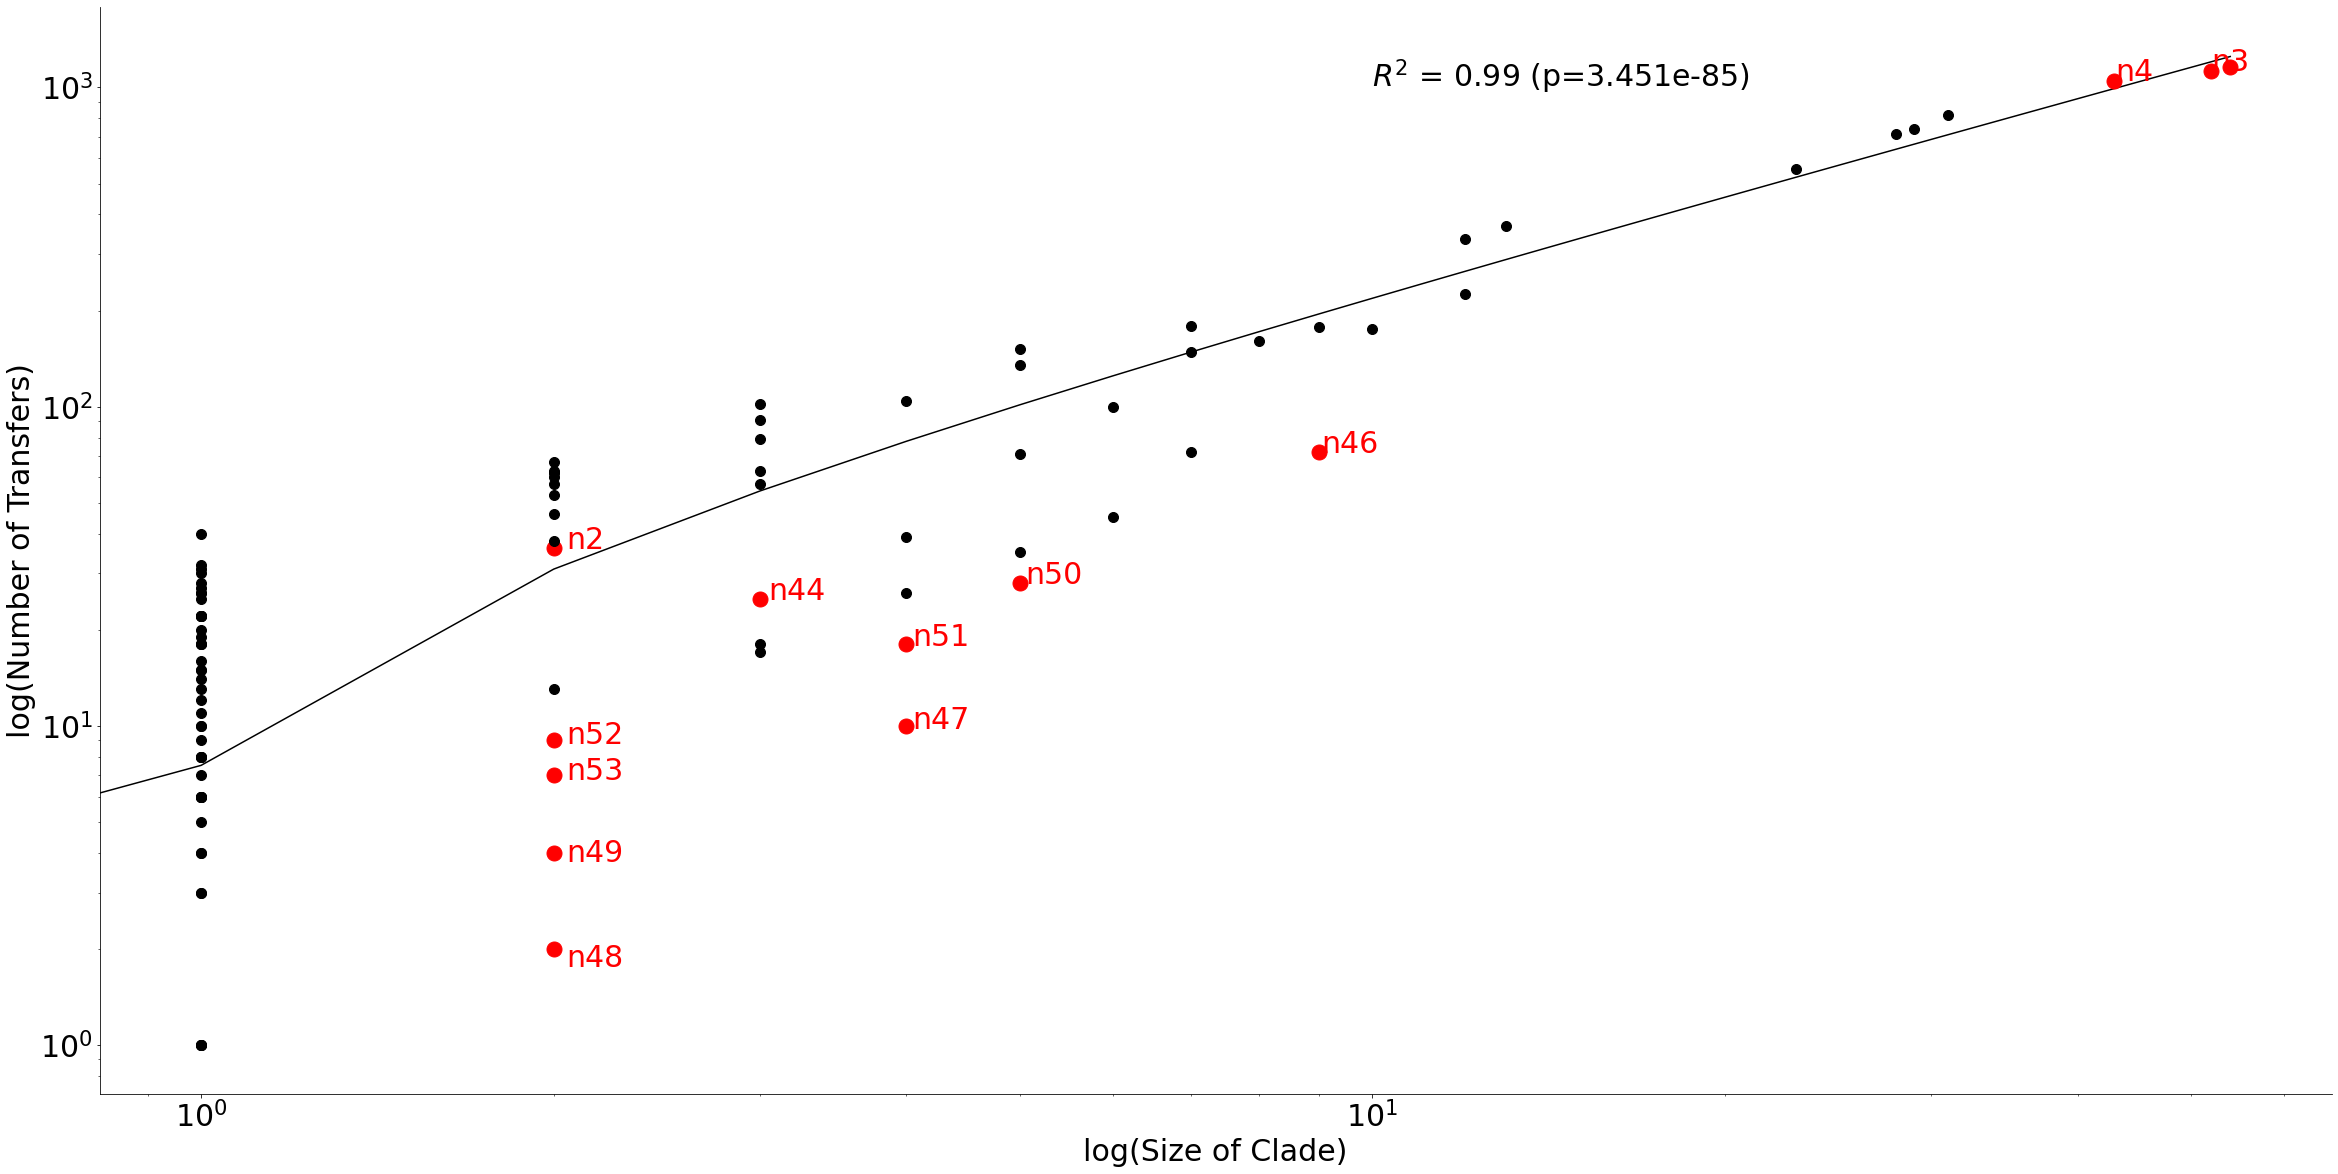

In [169]:
import matplotlib
fig = plt.gcf()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
plt.xscale('log')
plt.yscale('log')
fig.set_size_inches(40, 20)
#plt.scatter(lens,bothTreeList)
plt.plot(np.arange(0,max(lens)+1), AllfitCoef * np.arange(0,max(lens)+1) + AllfitIntercept, color='black')
#plt.plot(np.arange(0,max(lensWithout)+1), fitCoef * np.arange(0,max(lensWithout)+1) + fitIntercept, color='black')
#plt.plot(np.arange(min(lensSARS),max(lensSARS)+2), HufitCoef * np.arange(0,max(lensSARS)+1) + HufitIntercept, color='red')
for n, x, y in zip(names, lens, bothTreeList):
    if n in ['n46','n47','n48','n49','n50','n51','n52','n53', 'n2', 'n3', 'n4','n44','']:
        plt.plot(x,y,'ro',label=n,c='red',markersize=15)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='medium',c='red')
    elif n.startswith('n'):
        #print(n,x,y)
        #plt.text(x=x, y=y, s=n, fontsize='small')
        plt.plot(x,y,'ro',label=n,c='black',markersize=10)
    else:
        plt.plot(x,y,'ro',label=n,c='black',markersize=10)
plt.text(x=10, y= 1000, s='$R^2$ = {:.2f} (p={:.3e})'.format(AllfitR, AllfitPval),c='black')
# plt.text(x=10, y= 1000, s='$R^2$ = {:.2f} (p={:.3e})'.format(fitR, fitPval),c='black')
#plt.text(x=10, y= 10, s='$R^2$ = {:.2f} (p={:.3e})'.format(HufitR, HufitPval),c='red')
plt.xlabel('log(Size of Clade)')
plt.ylabel('log(Number of Transfers)')
sns.despine()
#plt.legend()
#plt.savefig('../fig/RecombinationRates_logBoth_fitTogether.svg')
plt.show()

In [84]:
bothNormList = []
for nt in transferDictNormalized.values():
    bothNormList.append(nt.treeIn + nt.treeOut)

In [85]:
s = 0
i = 0
for k, nt in transferDictNormalized.items():
    both = nt.treeIn + nt.treeOut
    if both >= np.quantile(bothNormList,0.95):
        s += both
        i += 1
        print(k, both, s, s / sum(bothNormList))
print(i / len(bothTreeList))

n34 31.5 31.5 0.01939818847333273
SC2018 31.0 62.5 0.038488469193120496
n26 34.0 96.5 0.05942619643417805
Rs4084 40.0 136.5 0.08405881671777517
n18 33.5 170.0 0.10468863620528775
Rs7327 32.0 202.0 0.12439473243216545
n24 31.0 233.0 0.14348501315195322
0.06542056074766354


In [86]:
print(np.quantile(bothNormList,0.95))
{k: v for k, v in sorted(transferDictNormalized.items(), key=lambda item: item[1].treeIn + item[1].treeOut, reverse=True) if v.treeIn + v.treeOut >= 0}

31.0


{'Rs4084': 14.00 26.00 14.00 26.00 0.00 1.00,
 'n26': 9.00 10.00 16.33 17.67 0.00 3.00,
 'n18': 4.00 10.00 16.00 17.50 0.00 2.00,
 'Rs7327': 15.00 17.00 15.00 17.00 0.00 1.00,
 'n34': 8.00 3.00 12.50 19.00 0.00 2.00,
 'SC2018': 20.00 11.00 20.00 11.00 0.00 1.00,
 'n24': 5.00 10.00 17.00 14.00 0.00 2.00,
 'n8': 6.00 2.00 15.80 14.60 0.00 5.00,
 'n10': 7.00 4.00 14.67 15.67 0.00 3.00,
 'F46': 12.00 18.00 12.00 18.00 0.00 1.00,
 'n11': 6.00 4.00 13.00 17.00 0.00 2.00,
 'n27': 3.00 6.00 13.50 15.00 0.00 2.00,
 'n13': 4.00 6.00 13.77 14.54 0.00 13.00,
 'Rp3': 19.00 9.00 19.00 9.00 0.00 1.00,
 'n14': 12.00 10.00 13.58 14.42 0.00 12.00,
 'n15': 3.00 8.00 13.80 13.20 0.00 5.00,
 'Rs4231': 14.00 13.00 14.00 13.00 0.00 1.00,
 'n9': 0.00 3.00 14.50 12.00 0.00 2.00,
 'n5': 11.00 7.00 13.32 13.16 0.00 31.00,
 'n23': 0.00 6.00 11.67 14.67 0.00 3.00,
 'Rs672': 13.00 13.00 13.00 13.00 0.00 1.00,
 'n22': 7.00 5.00 11.50 14.50 0.00 4.00,
 'As6526': 14.00 12.00 14.00 12.00 0.00 1.00,
 'n19': 10.00 2.00 1

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


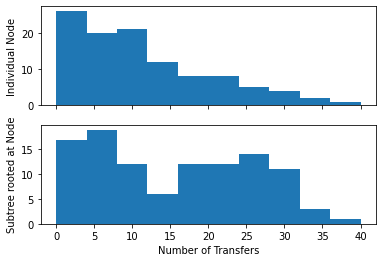

In [87]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].hist(bothList)
ax[0].set_ylabel('Individual Node')
ax[1].hist(bothNormList)
ax[1].set_ylabel('Subtree rooted at Node')
plt.xlabel('Number of Transfers')
plt.savefig('../fig/transfer_hub_histograms.svg')
plt.show()

In [ ]:
# from ete3 import AttrFace, TreeStyle

# # custom layout: adds "rank" on top of branches, and sci_name as tip names
# def my_layout(node):
#     if getattr(node, "nt", None):
#         nt_face = AttrFace("nt", fsize=7, fgcolor="indianred")
#         node.add_face(nt_face, column=0, position="branch-top")
#     if getattr(node, "name", None):
#         name_face = AttrFace("name", fsize=9, fgcolor="steelblue")
#         node.add_face(name_face, column=0, position="branch-right")
# ts = TreeStyle()
# ts.layout_fn = my_layout
# ts.show_leaf_name = False
# # speciesTree.show(tree_style=ts)
# #speciesTree.render("speciesTreeNumTransfers.svg", tree_style=ts)
# speciesTree.render("speciesTreeNumTransfersNormalized.png", tree_style=ts)